In [1]:
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import RFclass 

In [2]:
from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import RandomForestClassifier as RFC


from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from scipy.interpolate import spline
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.gaussian_process import GaussianProcess
import timeit

import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.interpolate import spline
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
import re
from astropy.io.fits.header import Header
from matplotlib.pyplot import xlim

%matplotlib inline

In [3]:

# Load data set and target values
start = timeit.default_timer()

####### Read the source data######################
df =pd.read_csv('Source_Data.csv', header=0)


p= Preprocessdata.standardprocess()

save_path = '/home/peng/git/Machine_learning_for_reliability_analysis/Ensemble/Results/'
result_name = 'rf_auc_10CV_.csv'

#train, trainlabel, test, testlabel = p.scaledivd(df, 0.8)
#print (np.shape(train))

In [4]:
#### scale the training dataset first and then apply the rules to test set 
#train, trainlabel, test, testlabel = p.scale(df, 0.8)
train, trainlabel, test, testlabel = p.sep_scale_divd(df, 0.8)
print (np.mean(testlabel))

validate_train = train[0:120,:]
validate_trainlabel = trainlabel[0:120]
train_train = train[120:,:]
train_trainlabel = trainlabel[120:]

0.5


In [5]:
### try autoencoding here 1. layout of the NN
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 6  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(12,))
# "encoded" is the encoded representation of the input
encoded = Dense(6, activation='relu')(input_img)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(12, activation='sigmoid')(encoded)


# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)





Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5005)


In [7]:
### 2. Optimizer for autoencoding 
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [8]:
## 3. train the autoencoder
autoencoder.fit(train_train, train_train,
                nb_epoch=2000,
                batch_size=120,
                shuffle=True,
                validation_data=(validate_train, validate_train))


Train on 8 samples, validate on 120 samples
Epoch 1/2000
8/8 [==============================] - 0s - loss: 0.6956 - val_loss: 0.7030
Epoch 2/2000
8/8 [==============================] - 0s - loss: 0.6954 - val_loss: 0.7028
Epoch 3/2000
8/8 [==============================] - 0s - loss: 0.6951 - val_loss: 0.7026
Epoch 4/2000
8/8 [==============================] - 0s - loss: 0.6949 - val_loss: 0.7024
Epoch 5/2000
8/8 [==============================] - 0s - loss: 0.6946 - val_loss: 0.7022
Epoch 6/2000
8/8 [==============================] - 0s - loss: 0.6944 - val_loss: 0.7020
Epoch 7/2000
8/8 [==============================] - 0s - loss: 0.6941 - val_loss: 0.7018
Epoch 8/2000
8/8 [==============================] - 0s - loss: 0.6938 - val_loss: 0.7016
Epoch 9/2000
8/8 [==============================] - 0s - loss: 0.6936 - val_loss: 0.7014
Epoch 10/2000
8/8 [==============================] - 0s - loss: 0.6933 - val_loss: 0.7012
Epoch 11/2000
8/8 [==============================] - 0s - loss: 0

In [103]:
train_new = autoencoder.predict(train)
print(np.shape(train_new))
test_new = autoencoder.predict(test)
print(np.shape(test_new))

(128, 12)
(32, 12)


In [104]:
train= train_new
test = test_new

In [105]:
#define the BO function
seed = 'rf'
rad_stat = 2

def rfccv(n_estimators, max_features):
    return cross_val_score(RFC(n_estimators=int(n_estimators),                               
                               max_features=min(max_features, 0.999),
                               random_state=2),
                           train, trainlabel, 'roc_auc', cv=10, n_jobs = -1).mean()

In [106]:
rfcBO = BayesianOptimization(rfccv, {'n_estimators': (64, 128),                                         
                                         'max_features': (0.1, 0.999)})
rfcBO.maximize()

print('Final Results')
print('RF: %f' % rfcBO.res['max']['max_val'])

Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    1 | 00m00s |    0.76083 |         0.3794 |        73.4128 | 
    2 | 00m00s |    0.75249 |         0.4441 |        68.4018 | 
    3 | 00m00s |    0.74388 |         0.8688 |        77.2874 | 
    4 | 00m00s |    0.75009 |         0.5542 |       110.2612 | 
    5 | 00m00s |    0.73498 |         0.8629 |       119.7127 | 
Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    6 | 00m04s |    0.75471 |         0.3408 |        77.7062 | 
    7 | 00m01s |    0.76601 |         0.3776 |        64.1416 | 
    8 | 00m01s |    0.76601 |         0.3602 |        64.0000 | 
    9 | 00m01s |    0.75377 |         0.1000 |        71.6997 | 
   10 | 00m01s |    0.76601 |         0.3691 |        64.0000 | 
   11 | 00m02s |    0.74867 |         0.1606 |        6

In [107]:
# use exploration to get better results
import random
from operator import add, sub

ops = (add, sub)
op = random.choice(ops)

tree_best = np.int(rfcBO.res['max']['max_params']['n_estimators'])
feature_best= np.float(rfcBO.res['max']['max_params']['max_features'])

new_tree_points, new_feature_points = [],[]

for i in xrange(0,5):
    new_tree_points.append(op(tree_best, tree_best*0.1*i) )
    new_feature_points.append(op(feature_best, feature_best*0.1*i) )



#new_feature_points = np.linspace(feature_best/2, feature_best*1.5, num = len(new_tree_points))
#new_feature_points.append(feature_best)

rfcBO_new = BayesianOptimization(rfccv, {'n_estimators': (64, 128),                                         
                                         'max_features': (0.1, 0.999)})
rfcBO_new.explore({'n_estimators': new_tree_points, 'max_features': new_feature_points})


rfcBO_new.maximize()

print('Final Results')
print('RF: %f' % rfcBO_new.res['max']['max_val'])


Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    1 | 00m00s |    0.76953 |         0.2845 |       121.0000 | 
    2 | 00m00s |    0.76156 |         0.2560 |       108.9000 | 
    3 | 00m00s |    0.75564 |         0.2276 |        96.8000 | 
    4 | 00m00s |    0.75249 |         0.1991 |        84.7000 | 
    5 | 00m00s |    0.75499 |         0.1707 |        72.6000 | 
    6 | 00m00s |    0.75286 |         0.1839 |        77.8239 | 
    7 | 00m00s |    0.75527 |         0.4771 |        77.7163 | 
    8 | 00m00s |    0.75655 |         0.1442 |        74.1331 | 
    9 | 00m00s |    0.75629 |         0.9326 |        82.9974 | 
   10 | 00m00s |    0.76341 |         0.1191 |       108.3104 | 
Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
   11 | 00m03s |    0.76953 |         0.2641 |       12

In [108]:
# get the best parameters for plotting auc on training and test
if (1): ### True use the above best parameters, false use the recored best set
    tree_best = np.int(rfcBO_new.res['max']['max_params']['n_estimators'])
    feature_best= np.float(rfcBO_new.res['max']['max_params']['max_features'])
    print ('use the latest records')

else:
    tree_best = np.int(70.3800)
    feature_best=0.7260
    print ('use the historical records')


bestmodel= RFC(n_estimators = tree_best, max_features = feature_best).fit(train,trainlabel)

print (tree_best, feature_best)

use the latest records
121 0.284481106726


In [79]:
#directly use RFC without optimizing parameters(Bayesian optimzation)


bestmodel= RFC(n_estimators = 100).fit(train,trainlabel)
tree_best = 100
feature_best = None
rad_stat = 2

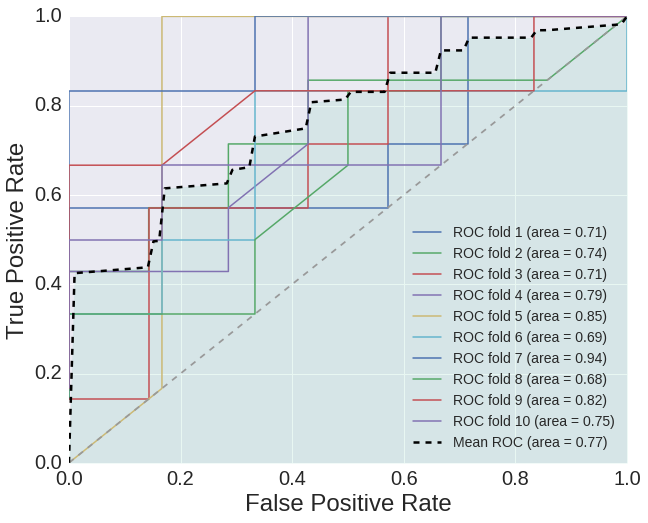

In [125]:
#use the best parameters to plot cv auc on the training set
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

figsize(10,8)
cv = StratifiedKFold(trainlabel, n_folds=10)

bestmodel_training= RFC(n_estimators = tree_best, max_features = feature_best, 
                            random_state = rad_stat)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (training, testing) in enumerate(cv):
    probas_ = bestmodel_training.fit(train[training], trainlabel[training]).predict_proba(train[testing])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(trainlabel[testing], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 14)

plt.fill_between(mean_fpr, 0, mean_tpr, #color="#348ABD", 
                 color="#66cdaa", alpha=0.15)
plt.show()

In [110]:
#predict the test set

tt=RFclass.test()

result = tt.testforest_score(test, testlabel,bestmodel)
print (result)

*******************************************
[[10  6]
 [ 4 12]]


*******************************************


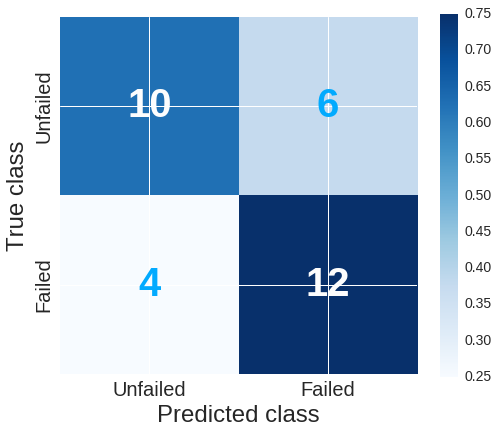

In [111]:
#plot the confusion matrix on test set
import Superplot
from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report

pp = Superplot.fancy()
pp.plot_confusion_matrix(result)

In [112]:
#plot the auc on test set
from sklearn.metrics import roc_curve, auc

y_score = bestmodel.predict_proba(test)
#print (y_score)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

In [113]:
print (y_score)

[[ 0.61983471  0.38016529]
 [ 0.91735537  0.08264463]
 [ 0.12396694  0.87603306]
 [ 0.5785124   0.4214876 ]
 [ 0.04958678  0.95041322]
 [ 0.43801653  0.56198347]
 [ 0.          1.        ]
 [ 0.26446281  0.73553719]
 [ 0.00826446  0.99173554]
 [ 0.92561983  0.07438017]
 [ 0.43801653  0.56198347]
 [ 0.96694215  0.03305785]
 [ 0.34710744  0.65289256]
 [ 0.0661157   0.9338843 ]
 [ 0.27272727  0.72727273]
 [ 0.8677686   0.1322314 ]
 [ 0.32231405  0.67768595]
 [ 0.61157025  0.38842975]
 [ 0.89256198  0.10743802]
 [ 0.49586777  0.50413223]
 [ 0.12396694  0.87603306]
 [ 0.81818182  0.18181818]
 [ 0.09917355  0.90082645]
 [ 0.96694215  0.03305785]
 [ 0.31404959  0.68595041]
 [ 0.70247934  0.29752066]
 [ 0.45454545  0.54545455]
 [ 0.12396694  0.87603306]
 [ 0.52892562  0.47107438]
 [ 0.58677686  0.41322314]
 [ 0.44628099  0.55371901]
 [ 0.97520661  0.02479339]]


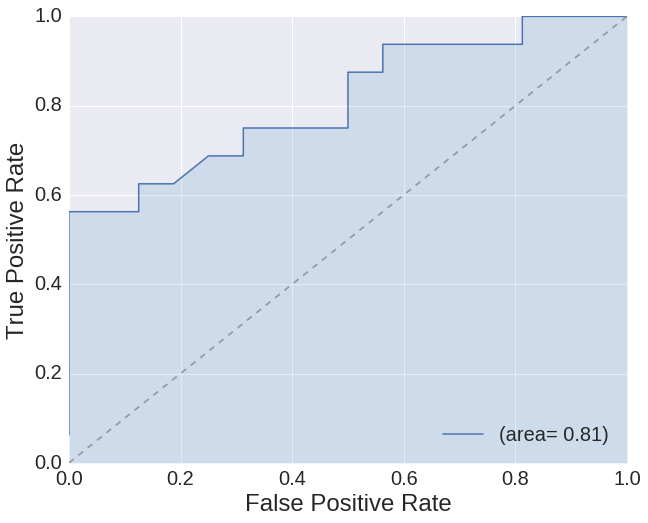

In [114]:
#plot the auc on test set
fpr, tpr, thresholds = roc_curve(testlabel, y_score[:, 1])
roc_auc = auc(fpr, tpr)

figsize(10,8)

plt.plot(fpr, tpr, lw=1.5, label='(area= %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr, 0, tpr, color="#348ABD", alpha=0.15)
plt.show()

This is for training set**************************************
************************this is the output of relative importance**************
[ 7  2  6  8 10  9  5  3 11  4  0  1]
Feature ranking:
1. feature 7 (0.219437)
2. feature 2 (0.114714)
3. feature 6 (0.097791)
4. feature 8 (0.097669)
5. feature 10 (0.082795)
6. feature 9 (0.071952)
7. feature 5 (0.062994)
8. feature 3 (0.062782)
9. feature 11 (0.059429)
10. feature 4 (0.050070)
11. feature 0 (0.047728)
12. feature 1 (0.032639)


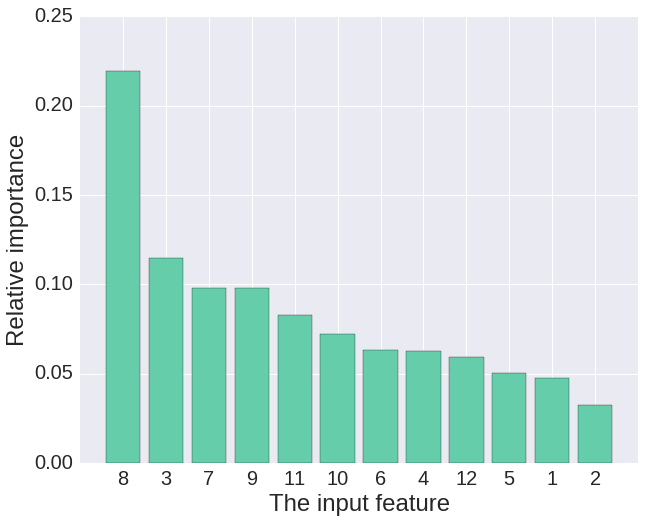

In [78]:
ff= RFclass.training()
ff.importance(bestmodel, 12, color = '#66cdaa', plot_std = False)


In [119]:
import pandas as pd
y_score = pd.DataFrame({'y_weak':y_score[:,1]})

print (y_score)

      y_weak
0   0.380165
1   0.082645
2   0.876033
3   0.421488
4   0.950413
5   0.561983
6   1.000000
7   0.735537
8   0.991736
9   0.074380
10  0.561983
11  0.033058
12  0.652893
13  0.933884
14  0.727273
15  0.132231
16  0.677686
17  0.388430
18  0.107438
19  0.504132
20  0.876033
21  0.181818
22  0.900826
23  0.033058
24  0.685950
25  0.297521
26  0.545455
27  0.876033
28  0.471074
29  0.413223
30  0.553719
31  0.024793


In [120]:
y_score.to_csv(save_path +'auc_compare.csv', header = True)